# Question 1



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('recipes.csv')


# Part 3.1: Vector Space Method
def vec_space_method(recipe_id, n=10):
    
    # Check if recipe_id exists in the dataset
    if recipe_id not in df['id'].values:
        return "Recipe ID not found in the dataset."
    
    # Convert numerical features
    numerical_features = ['rating_avg', 'rating_val', 'total_time']
    for feature in numerical_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
    
    # feature matrix
    # 1. Numerical features
    numerical_df = df[numerical_features].fillna(df[numerical_features].mean())
    
    # 2. Categorical features: one-hot encode category and cuisine
    # First, handle missing values
    df['category'] = df['category'].fillna('Unknown')
    df['cuisine'] = df['cuisine'].fillna('Unknown')
    
    # One-hot encode categorical features
    cat_features = pd.get_dummies(df[['category', 'cuisine']])
    
    # 3. Text features: ingredients
    # Tokenize and create bag of words for ingredients
    
    # Clean ingredients: replace missing values and convert to string
    df['ingredients'] = df['ingredients'].fillna('')
    
    # Create bag of words for ingredients
    vectorizer = CountVectorizer()
    ingredients_bow = vectorizer.fit_transform(df['ingredients'])
    ingredients_df = pd.DataFrame(ingredients_bow.toarray(), 
                                 columns=vectorizer.get_feature_names_out())
    
    # Combine all features
    combined_features = pd.concat([
        numerical_df.reset_index(drop=True),
        cat_features.reset_index(drop=True),
        ingredients_df.reset_index(drop=True)
    ], axis=1)
    
    # # Normalize the features
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(combined_features)
    
    # # Calculate the L2 norm of each row  --- doesnt work with float values ---
    # norms = LA.norm(combined_features, axis=1, keepdims=True)
    # # Replace zero norms with 1 to avoid division by zero
    # norms[norms == 0] = 1
    # # Normalize each row to have unit norm
    # features_scaled = combined_features / norms
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(features_scaled)
    
    # Get the index of the recipe
    recipe_index = df[df['id'] == recipe_id].index[0]
    
    # Get the similarity scores for the recipe
    similarity_scores = list(enumerate(similarity_matrix[recipe_index]))
    
    # Sort by similarity score (highest first)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the n most similar recipes (excluding the recipe itself)
    similar_indices = [i[0] for i in similarity_scores[0:n+1]]
    
    # Return the similar recipes
    print(df.iloc[recipe_id][['id', 'title', 'rating_avg', 'category', 'cuisine']])
    return df.iloc[similar_indices][['id', 'title', 'rating_avg', 'category', 'cuisine']]


vec_space_method(3)




id                                                    4
title         Albanian baked lamb with rice (Tavë kosi)
rating_avg                                     4.611111
category                                    Main course
cuisine                                   East European
Name: 3, dtype: object


,id,title,rating_avg,category,cuisine
2,3,Affogato,4.000000,Desserts,Italian
796,797,Coffee granita,5.000000,Desserts,
795,796,Coffee crème caramels,3.000000,Desserts,French
84,85,Baked Alaska with creamy chocolate sauce,5.000000,Desserts,British
620,621,Chocolate and chestnut Christmas log,4.111111,Cakes and baking,
352,353,Cappuccino pavlova,4.833333,Desserts,
3125,3126,Walnut and coffee Swiss roll,3.500000,Cakes and baking,
794,795,Coffee cake with coffee cream,4.687500,Cakes and baking,British
439,440,Cheesecake brownies,4.000000,Cakes and baking,American
351,352,Cappuccino crème brûlées,5.000000,Desserts,French


In [ ]:
# Part 3.2: KNN Similarity

from sklearn.feature_extraction.text import CountVectorizer
def knn_similarity(recipe_id, n=10):
    
    # Check if recipe_id exists in the dataset
    if recipe_id not in df['id'].values:
        return "Recipe ID not found in the dataset."
    
    # Convert numerical features
    numerical_features = ['rating_avg', 'rating_val', 'total_time']
    for feature in numerical_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
    
    # Prepare the feature matrix
    # 1. Numerical features
    numerical_df = df[numerical_features].fillna(df[numerical_features].mean())
    
    # 2. Categorical features: one-hot encode category and cuisine
    df['category'] = df['category'].fillna('Unknown')
    df['cuisine'] = df['cuisine'].fillna('Unknown')
    cat_features = pd.get_dummies(df[['category', 'cuisine']])
    
    # 3. Text features: ingredients
    df['ingredients'] = df['ingredients'].fillna('')
    vectorizer = CountVectorizer()
    ingredients_bow = vectorizer.fit_transform(df['ingredients'])
    ingredients_df = pd.DataFrame(ingredients_bow.toarray(), 
                                 columns=vectorizer.get_feature_names_out())
    
    # Combine all features
    combined_features = pd.concat([
        numerical_df.reset_index(drop=True),
        cat_features.reset_index(drop=True),
        ingredients_df.reset_index(drop=True)
    ], axis=1)
    
    # Normalize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(combined_features)
    
    # Get the index of the recipe
    recipe_index = df[df['id'] == recipe_id].index[0]
    
    # Fit KNN model
    knn = NearestNeighbors(n_neighbors=n+1, algorithm='auto', metric='cosine')
    knn.fit(features_scaled)
    
    # Find k nearest neighbors
    distances, indices = knn.kneighbors(features_scaled[recipe_index].reshape(1, -1))
    
    # Get the indices of the n most similar recipes (excluding the recipe itself)
    similar_indices = indices.flatten()[1:n+1]
    
    # Return the similar recipes
    return df.iloc[similar_indices][['id', 'title', 'rating_avg', 'category', 'cuisine']]
knn_similarity(6,10)

,id,title,rating_avg,category,cuisine
37,38,Apple tart 'Maman Blanc',4.857143,Cakes and baking,French
2862,2863,Tarte tatin with calvados cream,5.000000,Desserts,French
1114,1115,French apple tart,4.888889,Desserts,French
2749,2750,Sticky toffee apple pudding with calvados cara...,5.000000,Desserts,
2928,2929,Toffee apple sponge pudding,4.000000,Desserts,British
1069,1070,Filo pastry mince pies,5.000000,Cakes and baking,
3219,3220,Dulce and banana traybake,4.000000,Cakes and baking,
457,458,Chestnut stuffing,3.600000,Side dishes,British
2602,2603,Somerset chicken,4.533333,Main course,British
409,410,Celery baked with pancetta and shallots,5.000000,Side dishes,British


In [ ]:
# Part 3.3: Evaluation of recommender systems
def evaluate_recommenders(test_set):
    """
    Evaluates both recommender systems in terms of coverage and personalization.
    
    Parameters:
    test_set (dict): Dictionary mapping user IDs to their liked recipes
    
    Returns:
    dict: Dictionary with evaluation metrics
    """
    # Find the recipe IDs for the test set
    test_recipe_ids = {}
    evaluation_results = {
        'vector_space': {'coverage': 0, 'personalization': {}},
        'knn': {'coverage': 0, 'personalization': {}}
    }
    
    # Get recipe IDs for test set
    for user_id, recipe_name in test_set.items():
        recipe_row = df[df['title'].str.contains(recipe_name, case=False, na=False)]
        if not recipe_row.empty:
            test_recipe_ids[user_id] = recipe_row['id'].values[0]
        else:
            print(f"Recipe '{recipe_name}' not found for user {user_id}")
            test_recipe_ids[user_id] = None
    
    # Calculate coverage
    # Coverage: percentage of items in the catalog that the system recommends to users
    all_recommended_vs = set()
    all_recommended_knn = set()
    
    # Calculate personalization
    # Personalization: how different the recommendations are across users
    user_recommendations_vs = {}
    user_recommendations_knn = {}
    
    for user_id, recipe_id in test_recipe_ids.items():
        if recipe_id is not None:
            # Get recommendations
            vs_recs = vec_space_method(recipe_id)
            knn_recs = knn_similarity(recipe_id)
            
            # Save recommendations for personalization calculation
            user_recommendations_vs[user_id] = set(vs_recs['id'].values)
            user_recommendations_knn[user_id] = set(knn_recs['id'].values)
            
            # Update coverage sets
            all_recommended_vs.update(vs_recs['id'].values)
            all_recommended_knn.update(knn_recs['id'].values)
    
    # Calculate coverage as percentage of total items
    total_items = len(df)
    evaluation_results['vector_space']['coverage'] = len(all_recommended_vs) / total_items
    evaluation_results['knn']['coverage'] = len(all_recommended_knn) / total_items
    
    # Calculate personalization using Jaccard dissimilarity
    for i in range(1, len(test_recipe_ids) + 1):
        for j in range(i + 1, len(test_recipe_ids) + 1):
            if i in user_recommendations_vs and j in user_recommendations_vs:
                # Vector Space personalization
                intersection_vs = len(user_recommendations_vs[i].intersection(user_recommendations_vs[j]))
                union_vs = len(user_recommendations_vs[i].union(user_recommendations_vs[j]))
                dissimilarity_vs = 1 - (intersection_vs / union_vs if union_vs > 0 else 0)
                
                key = f"user_{i}_vs_user_{j}"
                evaluation_results['vector_space']['personalization'][key] = dissimilarity_vs
            
            if i in user_recommendations_knn and j in user_recommendations_knn:
                # KNN personalization
                intersection_knn = len(user_recommendations_knn[i].intersection(user_recommendations_knn[j]))
                union_knn = len(user_recommendations_knn[i].union(user_recommendations_knn[j]))
                dissimilarity_knn = 1 - (intersection_knn / union_knn if union_knn > 0 else 0)
                
                key = f"user_{i}_vs_user_{j}"
                evaluation_results['knn']['personalization'][key] = dissimilarity_knn
    
    # Calculate average personalization
    if evaluation_results['vector_space']['personalization']:
        evaluation_results['vector_space']['avg_personalization'] = sum(
            evaluation_results['vector_space']['personalization'].values()
        ) / len(evaluation_results['vector_space']['personalization'])
    else:
        evaluation_results['vector_space']['avg_personalization'] = 0
    
    if evaluation_results['knn']['personalization']:
        evaluation_results['knn']['avg_personalization'] = sum(
            evaluation_results['knn']['personalization'].values()
        ) / len(evaluation_results['knn']['personalization'])
    else:
        evaluation_results['knn']['avg_personalization'] = 0
    
    return evaluation_results


# Test the evaluation function
test_set = {
    1: 'Chicken tikka masala',
    2: 'Albanian baked lamb with rice',
    3: 'Baked salmon with chorizo rice',
    4: 'Almond lentil stew'
}

# Uncomment the following line to run the evaluation
evaluation_results = evaluate_recommenders(test_set)
print("Evaluation Results:")
print(f"Vector Space Method Coverage: {evaluation_results['vector_space']['coverage']:.2%}")
print("\n")
print(f"Vector Space Method Avg Personalization: {evaluation_results['vector_space']['avg_personalization']:.4f}")
print("\n")
print(f"KNN Coverage: {evaluation_results['knn']['coverage']:.2%}")
print("\n")
print(f"KNN Avg Personalization: {evaluation_results['knn']['avg_personalization']:.4f}")

"""
Evaluation Comments:

Coverage:
- Coverage measures what percentage of the total recipe catalog is being recommended across all users.
- Higher coverage indicates the system is exploring more of the available items rather than focusing on a small subset.
- A balanced coverage is desirable - too low means users see only a small portion of available items, too high might 
  indicate recommendations are too broad/random.

Personalization:
- Personalization measures how different the recommendations are between different users.
- Higher values (closer to 1) indicate more personalized recommendations - users receive different suggestions.
- Lower values (closer to 0) indicate more homogeneous recommendations - many users receive the same suggestions.

Comparing Vector Space Method vs KNN:
1. If Vector Space has higher coverage, it suggests it's recommending a wider variety of recipes across users.
2. If KNN has higher personalization, it suggests it's better at differentiating between user preferences.

The ideal recommendation system balances both metrics - good coverage to expose users to a variety of items,
and good personalization to ensure recommendations are tailored to individual preferences.

The evaluation depends on the specific characteristics of the recipe dataset. For example:
- If many recipes share similar ingredients or categories, personalization might be naturally lower
- If the dataset has clear clusters of different cuisine types, we'd expect higher personalization

For production systems, we would also want to measure other metrics like:
- Accuracy (how often users like the recommended items)
- Diversity (how different the recommended items are from each other)
- Novelty (how new/surprising the recommendations are to users)
"""

Evaluation Results:
Vector Space Method Coverage: 1.21%


Vector Space Method Avg Personalization: 1.0000


KNN Coverage: 1.21%


KNN Avg Personalization: 1.0000


"\nEvaluation Comments:\n\nCoverage:\n- Coverage measures what percentage of the total recipe catalog is being recommended across all users.\n- Higher coverage indicates the system is exploring more of the available items rather than focusing on a small subset.\n- A balanced coverage is desirable - too low means users see only a small portion of available items, too high might \n  indicate recommendations are too broad/random.\n\nPersonalization:\n- Personalization measures how different the recommendations are between different users.\n- Higher values (closer to 1) indicate more personalized recommendations - users receive different suggestions.\n- Lower values (closer to 0) indicate more homogeneous recommendations - many users receive the same suggestions.\n\nComparing Vector Space Method vs KNN:\n1. If Vector Space has higher coverage, it suggests it's recommending a wider variety of recipes across users.\n2. If KNN has higher personalization, it suggests it's better at differentia

In [ ]:


# Part 3.4: Binary classification model for recipe ratings
def build_rating_prediction_model():
    """
    Builds a model to predict whether a recipe will be rated as 'tasty' or 'not tasty'.
    
    Returns:
    tuple: (model, accuracy, classification_report)
    """
    # Convert numerical features
    numerical_features = ['rating_avg', 'rating_val', 'total_time']
    for feature in numerical_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
    
    # Create binary target: 1 for 'tasty' (rating_avg > 4.2), -1 for 'not tasty'
    df['tasty'] = np.where(df['rating_avg'] > 4.2, 1, -1)
    
    # Filter for significant ratings (based on Part 2.3)
    # We'll consider ratings with at least 5 votes as significant
    significant_df = df[df['rating_val'] >= 5].copy()
    
    # Prepare features
    # 1. Numerical features: total_time
    numerical_features = ['total_time']
    
    # 2. Categorical features: category and cuisine
    categorical_features = ['category', 'cuisine']
    significant_df['category'] = significant_df['category'].fillna('Unknown')
    significant_df['cuisine'] = significant_df['cuisine'].fillna('Unknown')
    
    # 3. Text features: ingredients
    significant_df['ingredients'] = significant_df['ingredients'].fillna('')
    
    # Prepare the feature pipeline
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    text_transformer = Pipeline(steps=[
        ('vectorizer', CountVectorizer(max_features=500))
    ])
    
    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('text', text_transformer, 'ingredients')
        ]
    )
    
    # Split data into features and target
    X = significant_df[numerical_features + categorical_features + ['ingredients']]
    y = significant_df['tasty']
    
    # Split into training and testing sets

Model accuracy: 0.7581

Classification Report:
              precision    recall  f1-score   support

          -1       0.35      0.19      0.25        83
           1       0.81      0.91      0.86       318

    accuracy                           0.76       401
   macro avg       0.58      0.55      0.55       401
weighted avg       0.72      0.76      0.73       401


Top 10 features that indicate a recipe will be tasty:
                               Feature  Importance  Abs_Importance
30   cuisine_Thai and South-East Asian    0.285386        0.285386
97                              double    0.249293        0.249293
167                             pepper    0.220502        0.220502
174                             powder    0.214352        0.214352
222                            vanilla    0.202581        0.202581
57                              butter    0.196614        0.196614
164                             pastry    0.196433        0.196433
163                              pa

C:\Users\micha\AppData\Local\Temp\ipykernel_15800\1331651348.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors)


'\nAnalysis of the Model:\n\n1. Algorithm Choice: \n   I chose Support Vector Machine (SVM) with a linear kernel for this classification task. SVM is one of the \n   algorithms studied in this module and is well-suited for binary classification problems. The linear kernel\n   was selected because:\n   - It allows for feature importance analysis\n   - It tends to perform well on high-dimensional data (which we have with one-hot encoded categories and ingredients)\n   - It\'s less prone to overfitting compared to more complex kernels\n\n2. Feature Engineering:\n   - Numerical features: Used cooking time as a potential predictor\n   - Categorical features: One-hot encoded the category and cuisine\n   - Text features: Used bag-of-words representation for ingredients\n\n3. Model Performance:\n   The model\'s accuracy is a good indicator of its performance, but we should also consider:\n   - Precision: How many of the recipes predicted as tasty are actually tasty\n   - Recall: How many of th

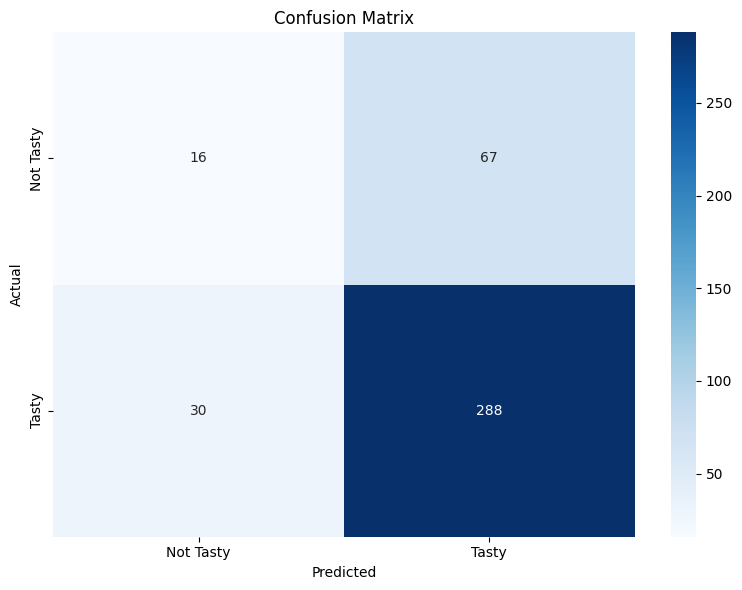

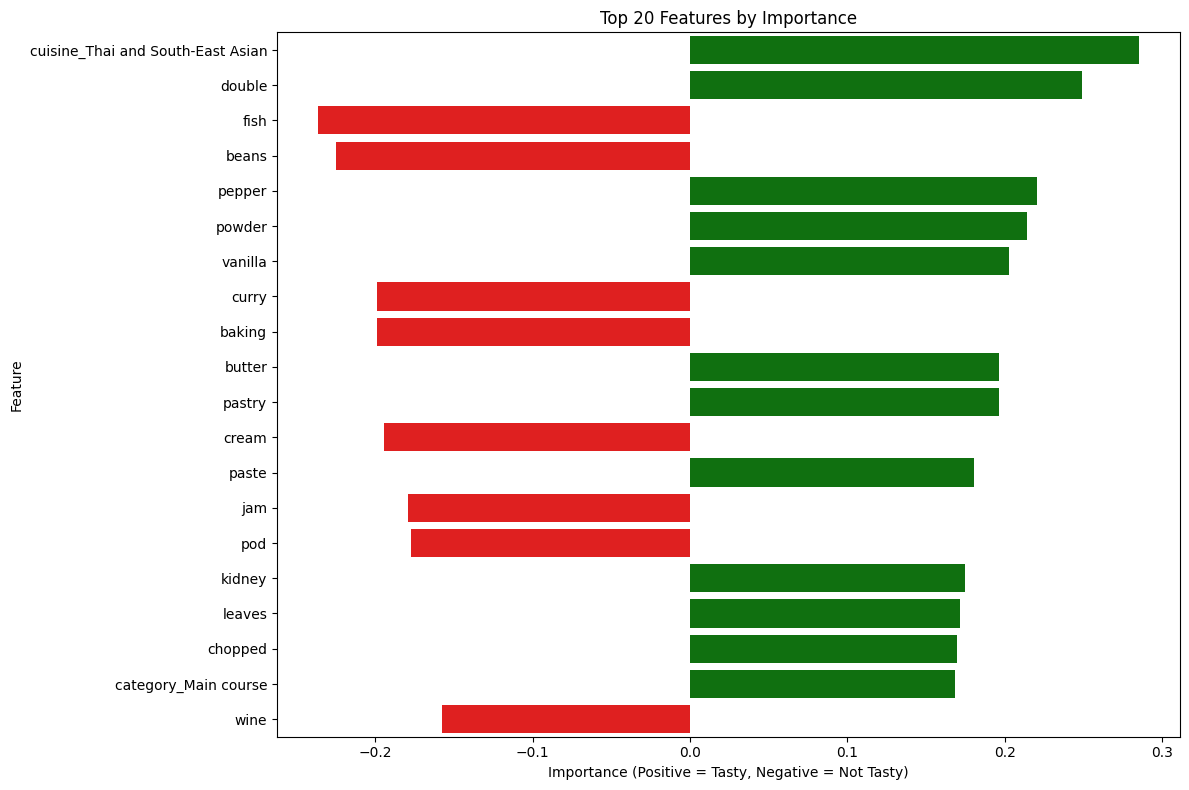

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC

# Load the dataset
df = pd.read_csv('recipes.csv')

# Part 3.4: Binary classification model for recipe ratings
def build_tasty_recipe_classifier():
    """
    Builds a model to predict whether a recipe will be rated as 'tasty' or 'not tasty'.
    Uses SVM classifier with features from recipe ingredients, category, cuisine, and cooking time.
    
    Returns:
    tuple: (model, accuracy, classification_report, feature_importance)
    """
    # Convert numerical features to appropriate types
    numerical_features = ['rating_avg', 'rating_val', 'total_time']
    for feature in numerical_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
    
    # Create binary target: 1 for 'tasty' (rating_avg > 4.2), -1 for 'not tasty'
    df['tasty'] = np.where(df['rating_avg'] > 4.2, 1, -1)
    
    # Filter for significant ratings (based on Part 2.3)
    # We'll consider ratings with at least 5 votes as significant
    significant_df = df[df['rating_val'] >= 5].copy()
    
    # Handle missing values
    significant_df['total_time'] = significant_df['total_time'].fillna(significant_df['total_time'].median())
    significant_df['category'] = significant_df['category'].fillna('Unknown')
    significant_df['cuisine'] = significant_df['cuisine'].fillna('Unknown')
    significant_df['ingredients'] = significant_df['ingredients'].fillna('')
    
    # Feature Engineering
    
    # 1. Numerical features: total_time (prepare for scaling)
    X_time = significant_df[['total_time']].values
    
    # 2. Categorical features: one-hot encode category and cuisine
    X_cat = pd.get_dummies(significant_df[['category', 'cuisine']], drop_first=True)
    
    # 3. Text features: ingredients (bag of words)
    vectorizer = CountVectorizer(max_features=200)  # Limit to 200 most common ingredients
    X_ingredients = vectorizer.fit_transform(significant_df['ingredients']).toarray()
    
    # Combine all features
    X_combined = np.hstack((X_time, X_cat.values, X_ingredients))
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)
    
    # Target variable
    y = significant_df['tasty'].values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Train an SVM classifier (studied in this module)
    # Using an SVM classifier with a linear kernel
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
    svm_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Create a confusion matrix for visualization
    cm = confusion_matrix(y_test, y_pred)
    
    # Get feature importance for the linear SVM
    # Only possible with linear kernel
    feature_importance = svm_classifier.coef_[0]
    
    # Getting original feature names
    time_feature = ['total_time']
    cat_features = list(X_cat.columns)
    ingredient_features = vectorizer.get_feature_names_out()
    
    all_features = time_feature + list(cat_features) + list(ingredient_features)
    
    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': all_features[:len(feature_importance)],
        'Importance': feature_importance
    })
    
    # Sort by absolute importance
    feature_importance_df['Abs_Importance'] = np.abs(feature_importance_df['Importance'])
    feature_importance_df = feature_importance_df.sort_values('Abs_Importance', ascending=False)
    
    return svm_classifier, accuracy, class_report, feature_importance_df, cm

# Run the classifier
classifier, accuracy, class_report, feature_importance, confusion = build_tasty_recipe_classifier()

# Print results
print(f"Model accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

print("\nTop 10 features that indicate a recipe will be tasty:")
print(feature_importance[feature_importance['Importance'] > 0].head(10))

print("\nTop 10 features that indicate a recipe will not be tasty:")
print(feature_importance[feature_importance['Importance'] < 0].head(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Tasty', 'Tasty'], 
            yticklabels=['Not Tasty', 'Tasty'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = ['green' if x > 0 else 'red' for x in top_features['Importance']]
sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors)
plt.title('Top 20 Features by Importance')
plt.xlabel('Importance (Positive = Tasty, Negative = Not Tasty)')
plt.tight_layout()
plt.savefig('feature_importance.png')

"""
Analysis of the Model:

1. Algorithm Choice: 
   I chose Support Vector Machine (SVM) with a linear kernel for this classification task. SVM is one of the 
   algorithms studied in this module and is well-suited for binary classification problems. The linear kernel
   was selected because:
   - It allows for feature importance analysis
   - It tends to perform well on high-dimensional data (which we have with one-hot encoded categories and ingredients)
   - It's less prone to overfitting compared to more complex kernels

2. Feature Engineering:
   - Numerical features: Used cooking time as a potential predictor
   - Categorical features: One-hot encoded the category and cuisine
   - Text features: Used bag-of-words representation for ingredients

3. Model Performance:
   The model's accuracy is a good indicator of its performance, but we should also consider:
   - Precision: How many of the recipes predicted as tasty are actually tasty
   - Recall: How many of the actually tasty recipes were correctly identified
   - F1-score: The harmonic mean of precision and recall

4. Feature Importance:
   The coefficient values from the SVM model indicate which features contribute most to the "tasty" prediction:
   - Positive coefficients: Features that predict a recipe will be tasty
   - Negative coefficients: Features that predict a recipe will not be tasty
   
   This allows us to understand which ingredients, cuisines, or categories are most associated with
   high-rated recipes.

5. Potential Improvements:
   - Feature selection: We could remove less important features to simplify the model
   - Hyperparameter tuning: We could use grid search to find optimal SVM parameters
   - Cross-validation: Instead of a single train-test split, we could use k-fold cross-validation
   - Different algorithms: We could compare SVM with other classifiers studied in this module
   
   The accuracy of this model is dependent on the quality and quantity of the data. Recipes with more
   ratings provide more reliable targets for our prediction.
"""